# setup

In [7]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

from tensorflow.python.keras.utils.data_utils import Sequence

sklearn version:  0.23.1
TF version:  2.6.0
GPU installed:  True
2 Physical GPUs, 2 Logical GPUs


# Get the data

In [8]:
#작성자 전민재
import csv
def load_Emist(exsitNumpy=False, needTranspose=True):
    if (exsitNumpy == False):
        #"./emnist-byclass-test.csv"
        #train-set
        #"공용/datasets/Emnist/" 위치에 csv 저장 
        csv_train_data_file = open("../공용/datasets/Emnist/train_data.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        csv_train_label_file = open("../공용/datasets/Emnist/train_label.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
    
        
        f_train = csv.reader(csv_train_data_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        l_train=csv.reader(csv_train_label_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        #valid-set
    
        csv_valid_data_file = open("../공용/datasets/Emnist/valid_data.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        csv_valid_label_file = open("../공용/datasets/Emnist/valid_label.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        
        f_valid = csv.reader(csv_valid_data_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        l_valid = csv.reader(csv_valid_label_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        X_train=[]
        y_train=[]
        X_valid=[]
        y_valid=[]
        for i, row in enumerate(f_train):
            #행마다 int로 형변환
            for idx, char in enumerate(row):
                row[idx]=int(char)
            #train
            #data 추가    
            X_train.append(row)
            
        for i, row in enumerate(f_valid):
            #행마다 int로 형변환
            for idx, char in enumerate(row):
                row[idx]=int(char)
            #valid
            #data 추가    
            X_valid.append(row)


        for i, row in enumerate(l_train):

            #train
            #label 추가
            y_train.append(int(row[0]))
            
        for i, row in enumerate(l_valid):

            #valid
            #label 추가
            y_valid.append(int(row[0]))
            
            
        

        #train
        X_train=np.array(X_train,dtype=np.uint8)
        X_train=X_train.reshape(-1,28,28)
        #valid
        X_valid=np.array(X_valid,dtype=np.uint8)
        X_valid=X_valid.reshape(-1,28,28)
        
        csv_train_data_file.close()
        csv_train_label_file.close()
        csv_valid_data_file.close()
        csv_valid_label_file.close()
        
        #kaggle dataset이 시계반대방향으로 90도 회전 되있고 상하 반전 되어있음
        def rotate_90(m):
            N = len(m)
            ret = [[0] * N for _ in range(N)]

            for r in range(N):
                for c in range(N):
                    ret[c][N-1-r] = m[r][c]
            return np.array(ret,dtype=np.uint8)

        def vreflect(m):
            N = len(m)
            ret = [[0] * N for _ in range(N)]

            for r in range(N):
                for c in range(N):
                    ret[r][c] = m[r][N-1-c]
            return np.array(ret,dtype=np.uint8)
        
        if needTranspose == True:
            #train
            #회전
            for idx,i in enumerate(X_train):
                X_train[idx]=rotate_90(i)
            #상하반전
            for idx,i in enumerate(X_train):
                X_train[idx]=vreflect(i)

            #valid
            #회전
            for idx,i in enumerate(X_valid):
                X_valid[idx]=rotate_90(i)
            #상하반전
            for idx,i in enumerate(X_valid):
                X_valid[idx]=vreflect(i)

       
        
        
        #저장용
        #train
        #(533917,28,28)
        
        np.save('../공용/X_train',np.array(X_train,dtype=np.uint8))
        np.save('../공용/y_train',np.array(y_train,dtype=np.uint8))
        #valid
        np.save('../공용/X_valid',np.array(X_valid,dtype=np.uint8))
        np.save('../공용/y_valid',np.array(y_valid,dtype=np.uint8))
        
   
    X_train=np.load('../공용/X_train.npy')
    y_train=np.load('../공용/y_train.npy')
    X_valid=np.load('../공용/X_valid.npy')
    y_valid=np.load('../공용/y_valid.npy')
    
    return X_train, y_train, X_valid, y_valid


In [49]:
#황성현
#npy 파일이 존재할 경우 exsitNumpy = True, 업으면 False
X_train, y_train, X_valid, y_valid = load_Emist(exsitNumpy=True)
X_train.shape,X_train.dtype

((533917, 28, 28), dtype('uint8'))

In [50]:
X_train_letters = X_train[np.where(y_train>10)]

In [51]:
y_train_letters = y_train[np.where(y_train>10)]

In [52]:
for i in range (3):
    X_train = np.append(X_train,X_train_letters,axis=0)
    y_train = np.append(y_train, y_train_letters,axis=0)

In [53]:
X_train.shape

(1329679, 28, 28)

In [11]:
del X_train_letters, y_train_letters



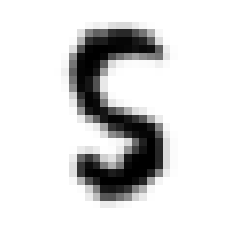

28


In [12]:
import cv2 as cv
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
ids=1
X_new=X_train[ids]
y_new=y_train[ids]
c=X_new.reshape(28,28)


plt.imshow(c, cmap="binary")
plt.axis('off')
plt.show()
print(y_new)

# Prepare the data

In [54]:
#황성현
#data, batch size 성정
train_size=len(X_train)
valid_size=len(X_valid)
batch_size=16
train_size

1329679

In [55]:
#황성현
X_train=np.reshape(X_train,[-1,784])
X_valid=np.reshape(X_valid,[-1,784])
X_train.shape,X_valid.shape

((1329679, 784), (164015, 784))

In [56]:
#황성현
y_train=np.reshape(y_train,[-1,1])
y_valid=np.reshape(y_valid,[-1,1])

y_train.shape,y_valid.shape

((1329679, 1), (164015, 1))

In [57]:
n_inputs = X_train.shape[-1]
print("n_inputs =",n_inputs)

n_inputs = 784


In [58]:
#황성현
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10, rewrite=False):
    
    Emnist_dir = os.path.join("../공용/datasets", "Emnist")
    os.makedirs(Emnist_dir, exist_ok=True)
    path_format = os.path.join(Emnist_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        if rewrite:
            
            try:
                with open(part_csv, "wt", encoding="utf-8") as f:
                    if header is not None:
                        f.write(header)
                        f.write("\n")
                    for row_idx in row_indices:
                        f.write(",".join([repr(col) for col in data[row_idx]]))
                        f.write("\n")
            except:
                continue
        else:
            try:
                with open(part_csv, "xt", encoding="utf-8") as f:
                    if header is not None:
                        f.write(header)
                        f.write("\n")
                    for row_idx in row_indices:
                        f.write(",".join([repr(col) for col in data[row_idx]]))
                        f.write("\n")
            except:
                continue
    return filepaths

In [59]:
train_full=np.append(X_train,y_train,axis=1)

In [60]:
train_full.shape

(1329679, 785)

In [17]:
#황성현
#메모리 해제
del X_train, y_train

In [18]:
import gc
gc.collect()

2244

In [61]:
#황성현
train_filepaths = save_to_multiple_csv_files(train_full, "train", n_parts=20,rewrite=True)

In [21]:
valid_full=np.append(X_valid,y_valid,axis=1)

In [21]:
#황성현
#메모리 해제
del X_valid, y_valid

In [22]:
import gc
gc.collect()

0

In [62]:
#황성현

valid_filepaths = save_to_multiple_csv_files(valid_full, "valid", n_parts=20)

In [24]:
#황성현
#메모리 해제
import gc
del valid_full, train_full
gc.collect()

0

In [63]:
#황성현
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

def dataaugmentation(X):
    datagen=ImageDataGenerator(rotation_range=40,width_shift_range = 0.2, 
        height_shift_range = 0.2)
    #영어 부분 2배 생성
    #차원변환 
    X=tf.reshape(X,[28,28,1])

    #새로운 데이터 생성
    angle=(random.random()%1)*0.8 - 0.4
    image_result =tfa.image.rotate(X, tf.constant(angle))#rotate -pi/10 ~ pi/10
    shift=(random.random()%1)*2 - 1
    image_result=tfa.image.translate(image_result,[tf.constant(shift),tf.constant(shift)])
    
    return image_result

In [64]:
#황성현
@tf.function
def preprocess_mobilenet_v2(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.mobilenet_v2.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_resnet50(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.resnet50.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_vgg16(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.vgg16.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_renet(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
   
    return augment_image, y

@tf.function
def preprocess_xception(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.xception.preprocess_input(resized_image)
    
    return final_image, y

@tf.function
def preprocess_inception_v3(line,randomize=False):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10 and randomize:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.inception_v3.preprocess_input(resized_image)
    
    return final_image, y

In [65]:
#황성현
from enum import Enum
class eModelName(Enum):
    mobilenet_v2 = 0,
    resnet50 = 1,
    vgg16 = 3,
    renet = 4,
    xception = 5,
    inception_v3 = 6
    

In [66]:
#황성현
from functools import partial
def csv_reader_dataset(filepaths, model_name, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32,randomize=True):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    if model_name == eModelName.mobilenet_v2:
        dataset = dataset.map(partial(preprocess_mobilenet_v2,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.resnet50:
        dataset = dataset.map(partial(preprocess_resnet50,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.vgg16:
        dataset = dataset.map(partial(preprocess_vgg16,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.renet:
        dataset = dataset.map(partial(preprocess_renet,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.xception:
        dataset = dataset.map(partial(preprocess_xception,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    elif model_name == eModelName.inception_v3:
        dataset = dataset.map(partial(preprocess_inception_v3,randomize=randomize), num_parallel_calls=n_parse_threads)
        print(model_name.name)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [67]:
#황성현
#csv_reader_dataset의 파라미터 model_name에 eModelNAme class의 맴버 변수 중 사용할 모델 입력
#ex) model_name = eModelName.inception_v3, model_name = eModelName.renet 
tf.random.set_seed(42)
np.random.seed(42)
train_set = csv_reader_dataset(train_filepaths, model_name = eModelName.mobilenet_v2, batch_size=batch_size, 
                               repeat=None,n_read_threads=tf.data.experimental.AUTOTUNE)
train_set_noaug = csv_reader_dataset(train_filepaths, model_name = eModelName.mobilenet_v2, batch_size=batch_size, 
                               repeat=None,n_read_threads=tf.data.experimental.AUTOTUNE, randomize = False)
valid_set = csv_reader_dataset(valid_filepaths, model_name = eModelName.mobilenet_v2, batch_size=batch_size, 
                               n_read_threads=tf.data.experimental.AUTOTUNE, repeat=None, randomize = False)
train_set_noaug,valid_set

mobilenet_v2
mobilenet_v2
mobilenet_v2


(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>)

# SMV2L

In [29]:
#황성현
class Inveted_Residual_Block(keras.layers.Layer):
    def __init__(self,c,s=1,t=1,n=1,**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.layers.ReLU(max_value=6)
        self.main_layers = [
            
            ]
        self.strides_layers=[
           ]
        self.s=s
        self.t=t
        self.c=c
        self.n=n
        
    def build(self,batch_input_shape):
        print(self.name,": batch_input_shape =",batch_input_shape)
        
        self.main_layers = [
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1, 
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=1,padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c,kernel_size=1, strides=1,padding="SAME", activation=self.activation),
            ]
        self.strides_layers=[
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1,
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=self.s,padding="SAME",activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c, kernel_size=1,strides=1,padding="SAME",activation=self.activation),
        ]

    def call(self, inputs):
        Z = inputs
        
        for n in range(0,self.n):
            if n == 0:
                for layer in self.strides_layers:
                    Z = layer(Z)
            else:
                skip_Z = Z
                for layer in self.main_layers:
                    Z = layer(Z)
                
                Z += skip_Z
    
        return Z
    
    def get_config(self):
        base=super().get_config()
        return{**base,"s":self.s,"t":self.t,"c":self.c,"n":self.n}

In [71]:
#황성현
#multygpu
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    n_classes=62
    smv2_l=keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[224,224,3]),
        keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding="same",activation="relu"),
        Inveted_Residual_Block(t=1,c=16,n=1,s=1,name="IRB1"),
        Inveted_Residual_Block(t=4,c=16,n=2,s=2,name="IRB2"),
        Inveted_Residual_Block(t=8,c=32,n=2,s=2,name="IRB3"),
        Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB4"),
        Inveted_Residual_Block(t=8,c=128,n=1,s=2,name="IRB5"),
        Inveted_Residual_Block(t=8,c=1024,n=1,s=1,name="IRB6"),
        keras.layers.ReLU(max_value=6),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(n_classes,activation="softmax")
    ])
    smv2_l.summary()
    smv2_l.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 16)
IRB4 : batch_input_shape = (None, 28, 28, 32)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_15 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
IRB1 (Inveted_Residual_Block (None, 112, 112, 16)      2288      
_________________________________________________________________
IRB2 (Inveted_Residual

In [41]:
#황성현 
from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2L%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
check_best_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2l_nadam_best.h5",save_best_only=True)
check_last_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2l_nadam_last.h5",save_best_only=True)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history=smv2_l.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size),
                    epochs=300,callbacks=[tboard_callback, check_best_cb, check_last_cb, earlystop_cb])

NameError: name 'smv2_l' is not defined

In [ ]:
smv2_l.save("smv2l_nadam_last.h5")

# SMV2P

In [36]:
#황성현
with strategy.scope():
    n_classes=62
    smv2_p=keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[224,224,3]),
        keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding="same",activation="relu"),
        Inveted_Residual_Block(t=1,c=16,n=1,s=1,name="IRB1"),
        Inveted_Residual_Block(t=4,c=32,n=2,s=2,name="IRB2"),
        Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB3"),
        Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB4"),
        Inveted_Residual_Block(t=8,c=128,n=1,s=2,name="IRB5"),
        Inveted_Residual_Block(t=8,c=1024,n=1,s=1,name="IRB6"),
        keras.layers.ReLU(max_value=6),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(n_classes,activation="softmax")
    ])
    smv2_p.summary()
    smv2_p.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])

IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 32)
IRB4 : batch_input_shape = (None, 28, 28, 64)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
IRB1 (Inveted_Residual_Block (None, 112, 112, 16)      2288      
_________________________________________________________________
IRB2 (Inveted_Residual_Block (None, 56, 56, 32)        9856      
_________________________________________________________________
IRB3 (Inveted_Residual_Block (None, 28,

In [79]:
#황성현 
from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2P%Y%m%d-%H%M%S")
print(logs)
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
check_best_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2p_nadam_best.h5",save_best_only=True)
check_last_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2p_nadam_last.h5",save_best_only=False)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history=smv2_p.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size),
                    epochs=300,callbacks=[tboard_callback, check_best_cb, check_last_cb, earlystop_cb])

Epoch 1/300
INFO:tensorflow:batch_all_reduce: 116 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 116 all-reduces with algorithm = nccl, num_packs = 1
41552/41552 [==============================] - 4478s 107ms/step - loss: 0.3839 - accuracy: 0.8680 - val_loss: 5.9704 - val_accuracy: 0.3080
Epoch 2/300
41552/41552 [==============================] - 4422s 106ms/step - loss: 0.3190 - accuracy: 0.8827 - val_loss: 2.1717 - val_accuracy: 0.6591
Epoch 3/300
41552/41552 [==============================] - 4420s 106ms/step - loss: 0.2998 - accuracy: 0.8894 - val_loss: 2.7346 - val_accuracy: 0.6143
Epoch 4/300
41552/41552 [==============================] - 4411s 106ms/step - loss: 0.3061 - accuracy: 0.8864 - val_loss: 1.8020 - val_accuracy: 0.7005
Epoch 5/300
41552/41552 [==============================] - 4424s 106ms/step - loss: 0.3005 - accuracy: 0.8882 - val_loss: 2.5975 - val_accuracy: 0.6392
Epoch 6/300
41552/41552 [==============================] - 4401s 1

min val loss = 1.3234 at 9 epoch

In [111]:
smv2_p=keras.models.load_model(
    "smv2p_nadam_best.h5",custom_objects={"Inveted_Residual_Block":Inveted_Residual_Block})

IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 32)
IRB4 : batch_input_shape = (None, 28, 28, 64)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)


In [80]:
%load_ext tensorboard

In [81]:
%tensorboard --logdir logs/SMV2P20220525-203629

Reusing TensorBoard on port 6006 (pid 17285), started 9:56:56 ago. (Use '!kill 17285' to kill it.)

In [87]:
smv2_p.evaluate(X_valid[np.where(y_valid>10)],y_valid[np.where(y_valid>10)])

INFO:tensorflow:Error reported to Coordinator: Input 0 of layer sequential_8 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (None, 28, 28)
Traceback (most recent call last):
  File "/home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/training/coordinator.py", line 297, in stop_on_exception
    yield
  File "/home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/distribute/mirrored_run.py", line 346, in run
    self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
  File "/home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py", line 692, in wrapper
    return converted_call(f, args, kwargs, options=options)
  File "/home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py", line 382, in converted_call
    return _call_unconverted(f, args, kwargs, options)
  File "/home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py", line 463, in

ValueError: in user code:

    /home/dsd/.local/lib/python3.6/site-packages/keras/engine/training.py:1330 test_function  *
        return step_function(self, iterator)
    /home/dsd/.local/lib/python3.6/site-packages/keras/engine/training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/distribute/mirrored_strategy.py:671 _call_for_each_replica
        self._container_strategy(), fn, args, kwargs)
    /home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/distribute/mirrored_run.py:104 call_for_each_replica
        return _call_for_each_replica(strategy, fn, args, kwargs)
    /home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/distribute/mirrored_run.py:246 _call_for_each_replica
        coord.join(threads)
    /home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/training/coordinator.py:389 join
        six.reraise(*self._exc_info_to_raise)
    /home/dsd/.local/lib/python3.6/site-packages/six.py:703 reraise
        raise value
    /home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/training/coordinator.py:297 stop_on_exception
        yield
    /home/dsd/.local/lib/python3.6/site-packages/tensorflow/python/distribute/mirrored_run.py:346 run
        self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
    /home/dsd/.local/lib/python3.6/site-packages/keras/engine/training.py:1313 run_step  **
        outputs = model.test_step(data)
    /home/dsd/.local/lib/python3.6/site-packages/keras/engine/training.py:1267 test_step
        y_pred = self(x, training=False)
    /home/dsd/.local/lib/python3.6/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/dsd/.local/lib/python3.6/site-packages/keras/engine/input_spec.py:218 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential_8 is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (None, 28, 28)


In [94]:
smv2p_pred=smv2_p.predict(valid_set,steps=int(valid_size/batch_size))

In [31]:
os.environ["TF_GPU_THREAD_MODE"]="gpu_private"

# smv2p fit no augmentation train set

In [42]:
#황성현
#multygpu
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    n_classes=62
    smv2_p_noaug=keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[224,224,3]),
        keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding="same",activation="relu"),
        Inveted_Residual_Block(t=1,c=16,n=1,s=1,name="IRB1"),
        Inveted_Residual_Block(t=4,c=32,n=2,s=2,name="IRB2"),
        Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB3"),
        Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB4"),
        Inveted_Residual_Block(t=8,c=128,n=1,s=2,name="IRB5"),
        Inveted_Residual_Block(t=8,c=1024,n=1,s=1,name="IRB6"),
        keras.layers.ReLU(max_value=6),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(n_classes,activation="softmax")
    ])
    smv2_p_noaug.summary()
    smv2_p_noaug.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 32)
IRB4 : batch_input_shape = (None, 28, 28, 64)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
IRB1 (Inveted_Residual_Block (None, 112, 112, 16)      2288      
_________________________________________________________________
IRB2 (Inveted_Residual

In [43]:
#황성현 
from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2P_NOAUG%Y%m%d-%H%M%S")
print(logs)
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
check_best_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2p_noaug_nadam_best.h5",save_best_only=True)
check_last_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2p_noaug_nadam_last.h5",save_best_only=False)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
lr_callback=keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
history2=smv2_p_noaug.fit(train_set_noaug, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size),
                    epochs=200,callbacks=[tboard_callback, check_best_cb, check_last_cb, earlystop_cb,lr_callback])

logs/SMV2P_NOAUG20220528-150031
Epoch 1/200
INFO:tensorflow:batch_all_reduce: 116 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 116 all-reduces with algorithm = nccl, num_packs = 1
16684/16684 [==============================] - 1862s 109ms/step - loss: 0.5501 - accuracy: 0.8159 - val_loss: 0.4324 - val_accuracy: 0.8431
Epoch 2/200
16684/16684 [==============================] - 1806s 108ms/step - loss: 0.4065 - accuracy: 0.8536 - val_loss: 18.6655 - val_accuracy: 0.0065
Epoch 3/200
16684/16684 [==============================] - 1809s 108ms/step - loss: 0.3934 - accuracy: 0.8566 - val_loss: 0.3841 - val_accuracy: 0.8563
Epoch 4/200
16684/16684 [==============================] - 1812s 109ms/step - loss: 0.3763 - accuracy: 0.8625 - val_loss: 0.3960 - val_accuracy: 0.8534
Epoch 5/200
16684/16684 [==============================] - 1817s 109ms/step - loss: 0.3763 - accuracy: 0.8615 - val_loss: 0.5103 - val_accuracy: 0.8172
Epoch 6/200
16684/16684 [========

KeyboardInterrupt: 

In [46]:
smv2_p_noaug.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"],
                    )

In [47]:
#황성현 
from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2P_NOAUG%Y%m%d-%H%M%S")
print(logs)
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
check_best_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2p_noaug_nadam_best.h5",save_best_only=True)
check_last_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2p_noaug_nadam_last.h5",save_best_only=False)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
lr_callback=keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5)
history2=smv2_p_noaug.fit(train_set_noaug, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size),
                    epochs=200,callbacks=[tboard_callback, check_best_cb, check_last_cb, earlystop_cb,lr_callback])

logs/SMV2P_NOAUG20220528-193809
ERROR:tensorflow:Failed to start profiler: Another profiler is running.
Epoch 1/200
INFO:tensorflow:batch_all_reduce: 116 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 116 all-reduces with algorithm = nccl, num_packs = 1
16684/16684 [==============================] - 1869s 111ms/step - loss: 0.3633 - accuracy: 0.8659 - val_loss: 0.3677 - val_accuracy: 0.8637
Epoch 2/200
16684/16684 [==============================] - 1879s 113ms/step - loss: 0.3564 - accuracy: 0.8670 - val_loss: 1.4050 - val_accuracy: 0.6574
Epoch 3/200
16684/16684 [==============================] - 1888s 113ms/step - loss: 0.3624 - accuracy: 0.8654 - val_loss: 1.2642 - val_accuracy: 0.6330
Epoch 4/200
16684/16684 [==============================] - 1860s 111ms/step - loss: 0.3583 - accuracy: 0.8664 - val_loss: 0.3631 - val_accuracy: 0.8652
Epoch 5/200
16684/16684 [==============================] - 1846s 111ms/step - loss: 0.3627 - accuracy: 0.8658 - va

# smv2p  augmentaion and /2 batchsize

In [48]:
#황성현
#multygpu
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    n_classes=62
    smv2_p=keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[224,224,3]),
        keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding="same",activation="relu"),
        Inveted_Residual_Block(t=1,c=16,n=1,s=1,name="IRB1"),
        Inveted_Residual_Block(t=4,c=32,n=2,s=2,name="IRB2"),
        Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB3"),
        Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB4"),
        Inveted_Residual_Block(t=8,c=128,n=1,s=2,name="IRB5"),
        Inveted_Residual_Block(t=8,c=1024,n=1,s=1,name="IRB6"),
        keras.layers.ReLU(max_value=6),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(n_classes,activation="softmax")
    ])
    smv2_p.summary()
    smv2_p.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 32)
IRB4 : batch_input_shape = (None, 28, 28, 64)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
IRB1 (Inveted_Residual_Block (None, 112, 112, 16)      2288      
_________________________________________________________________
IRB2 (Inveted_Residual

In [68]:
#황성현 
from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2P_NOAUG%Y%m%d-%H%M%S")
print(logs)
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
check_best_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2p_16batch_nadam_best.h5",save_best_only=True)
check_last_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2p_16batch_nadam_last.h5",save_best_only=False)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
lr_callback=keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5)
history2=smv2_p_noaug.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size),
                    epochs=200,callbacks=[tboard_callback, check_best_cb, check_last_cb, earlystop_cb,lr_callback])

logs/SMV2P_NOAUG20220529-104823
ERROR:tensorflow:Failed to start profiler: Another profiler is running.
Epoch 1/200
83104/83104 [==============================] - 5971s 72ms/step - loss: 0.3457 - accuracy: 0.8765 - val_loss: 0.7710 - val_accuracy: 0.8290
Epoch 2/200
83104/83104 [==============================] - 5945s 72ms/step - loss: 0.2933 - accuracy: 0.8917 - val_loss: 0.5857 - val_accuracy: 0.8388
Epoch 3/200
83104/83104 [==============================] - 5946s 72ms/step - loss: 0.2913 - accuracy: 0.8910 - val_loss: 0.6854 - val_accuracy: 0.8320
Epoch 4/200
83104/83104 [==============================] - 5957s 72ms/step - loss: 0.2801 - accuracy: 0.8942 - val_loss: 1.2329 - val_accuracy: 0.8005
Epoch 5/200
83104/83104 [==============================] - 5953s 72ms/step - loss: 0.2472 - accuracy: 0.9065 - val_loss: 1.4598 - val_accuracy: 0.7858
Epoch 6/200
83104/83104 [==============================] - 5956s 72ms/step - loss: 0.2490 - accuracy: 0.9048 - val_loss: 1.3215 - val_accurac

In [71]:
smv2p_test=keras.models.load_model("smv2p_noaug_nadam_best.h5",
                                 custom_objects={"Inveted_Residual_Block":Inveted_Residual_Block})

IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 32)
IRB4 : batch_input_shape = (None, 28, 28, 64)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)


In [73]:
smv2p_test.evaluate(valid_set,
                    steps=int(valid_size / batch_size))

10250/10250 [==============================] - 150s 14ms/step - loss: 0.3443 - accuracy: 0.8724


[0.3443429172039032, 0.8724329471588135]

In [74]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    smv2p_test=keras.models.load_model("smv2p_16batch_nadam_best.h5",
                                 custom_objects={"Inveted_Residual_Block":Inveted_Residual_Block})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 32)
IRB4 : batch_input_shape = (None, 28, 28, 64)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)


In [75]:
smv2p_test.evaluate(valid_set,
                    steps=int(valid_size / batch_size))

10250/10250 [==============================] - 151s 15ms/step - loss: 0.5826 - accuracy: 0.8386


[0.582583487033844, 0.838554859161377]

# SMV2B

In [33]:
#황성현
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    n_classes=62
    smv2_b=keras.models.Sequential([
        keras.layers.BatchNormalization(input_shape=[224,224,3]),
        keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding="same",activation="relu"),
        Inveted_Residual_Block(t=1,c=16,n=1,s=1,name="IRB1"),
        Inveted_Residual_Block(t=4,c=24,n=2,s=2,name="IRB2"),
        Inveted_Residual_Block(t=8,c=48,n=2,s=2,name="IRB3"),
        Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB4"),
        Inveted_Residual_Block(t=8,c=128,n=1,s=2,name="IRB5"),
        Inveted_Residual_Block(t=8,c=1024,n=1,s=1,name="IRB6"),
        keras.layers.ReLU(max_value=6),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(n_classes,activation="softmax")
    ])
    smv2_b.summary()
    smv2_b.compile(loss="sparse_categorical_crossentropy",
                   optimizer="nadam",
                   metrics=["accuracy"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
IRB1 : batc

In [33]:

from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2B%Y%m%d-%H%M%S")
# Clear out prior logging data.

logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict()
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)


In [34]:
#황성현 
from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2B%Y%m%d-%H%M%S")
check_best_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2b_nadam_best.h5",save_best_only=True)
check_last_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2b_nadam_last.h5",save_best_only=False)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
#cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')

history=smv2_b.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size),
                    epochs=300,callbacks=[tboard_callback, check_best_cb, check_last_cb, earlystop_cb])

Epoch 1/300
INFO:tensorflow:batch_all_reduce: 116 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 116 all-reduces with algorithm = nccl, num_packs = 1
41552/41552 [==============================] - 4266s 102ms/step - loss: 0.3992 - accuracy: 0.8621 - val_loss: 7.4812 - val_accuracy: 0.1981
Epoch 2/300
41552/41552 [==============================] - 4227s 102ms/step - loss: 0.3081 - accuracy: 0.8866 - val_loss: 1.8316 - val_accuracy: 0.6874
Epoch 3/300
41552/41552 [==============================] - 4222s 102ms/step - loss: 0.3090 - accuracy: 0.8856 - val_loss: 3.8341 - val_accuracy: 0.5182
Epoch 4/300
41552/41552 [==============================] - 4217s 101ms/step - loss: 0.3035 - accuracy: 0.8874 - val_loss: 3.2887 - val_accuracy: 0.5845
Epoch 5/300
41552/41552 [==============================] - 4226s 102ms/step - loss: 0.2921 - accuracy: 0.8913 - val_loss: 5.4356 - val_accuracy: 0.5173
Epoch 6/300
41552/41552 [==============================] - 4228s 1